In [1]:
##Functions and libraries
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
import torch
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import tensorflow as tf
from torch.utils.data import Dataset
from torchsummary import summary
import torch.nn as nn
import evaluate
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from fpdf import FPDF
from sklearn.metrics import f1_score, confusion_matrix

##Point to the local server and the model to be used and set up the stable prompt contents
client = OpenAI(base_url="http://127.0.0.1:1234/v1", api_key="lm-studio")
model = SentenceTransformer("all-MiniLM-L6-v2")

system_prompt =  "Rate how positive or a negative a clothing article review is. Only answer with a single digit from 0 to 4, use '0' for negative, '1' for somewhat negative, '2' for neutral, '3' for somewhat positive and '4' for positive. Do not answer with anything else than '0' or '1' or '2' or '3' or '4'."
system_prompt_RAG = "Rate how positive or a negative a clothing article review is. Only answer with a single digit from 0 to 4, use '0' for negative, '1' for somewhat negative, '2' for neutral, '3' for somewhat positive and '4' for positive. Do not answer with anything else than '0' or '1' or '2' or '3' or '4'. Use the ratings of the following similar reviews to make your decision. "
user_prompt_stable =  "Rate how positive or a negative a clothing article review is. Only answer with a single digit from 0 to 4, use '0' for negative, '1' for somewhat negative, '2' for neutral, '3' for somewhat positive and '4' for positive. Do not answer with anything else than '0' or '1' or '2' or '3' or '4'. The review goes as follows: "

##Dataset
# Decode the review froms the dataset, only relevant for IMDB
# def decode_reviews(sequences):
    
#     return [
#         " ".join([reverse_word_index.get(i - 3, "?") for i in sequence[1:]])
#         for sequence in sequences
#     ]


##Normal Prompting procedure
# API access to the model
def prompt_model(prompt):
    completion = client.chat.completions.create(
        model="llama-3-8b-lexi-uncensored",
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {"role": "user", "content": user_prompt_stable + str(prompt)},
        ],
        temperature=0,
    )
    return completion.choices[0].message.content


##RAG Magic
# Create vector embeddings for the reviews
def encode_text_list(text_list):
    embeddings = [model.encode(text) for text in text_list]
    return embeddings


# return the indices of the top n relevant reviews for retrieval
def calculate_top_n_similarities(prompt, stored_embeddings, top_n=3):
    # Encode the new prompt
    prompt_embedding = model.encode(prompt)

    # Calculate cosine similarity with each stored embedding
    similarities = [
        1 - cosine(prompt_embedding, emb) for emb in stored_embeddings
    ]  # 1 - cosine_distance = cosine_similarity. The higher the value, the more similar the vectors are

    # Get the indices of the top n similarities
    top_n_indices = np.argsort(similarities)[-top_n:][::-1]

    return top_n_indices


# construct context query for the model
def integrate_knowledge(stored_reviews, top_n_indices):
    # Define ordinal words for readability
    ordinals = [
        "The most similar",
        "The second most similar",
        "The third most similar",
        "The fourth most similar",
        "The fifth most similar",
        "The sixth most similar",
        "The seventh most similar",
        "The eighth most similar",
        "The ninth most similar",
        "The tenth most similar",
    ]
    # Construct the formatted string by integrating the reviews in the correct order
    integrated_string = system_prompt_RAG
    for i, idx in enumerate(top_n_indices):
        # Get the ordinal word based on index position, or use "next" if ordinals are exceeded
        ordinal_word = ordinals[i] if i < len(ordinals) else "next"
        # Append the formatted review to the integrated string
        integrated_string += f"{ordinal_word} review, {stored_reviews[idx]}"

    return integrated_string.strip()


# RAG-prompts for the model
def RAG_prompt_model(prompt, n_known_reviews=5):
    top_n_indices = calculate_top_n_similarities(prompt, stored_embeddings, top_n=n_known_reviews)
    integragted_prompt = integrate_knowledge(review_list, top_n_indices)
    completion = client.chat.completions.create(
        model="llama-3-8b-lexi-uncensored",
        messages=[
            {
                "role": "system",
                "content": integragted_prompt,
            },
            {"role": "user", 
             "content": user_prompt_stable+ str(prompt)},
        ],
        temperature=0,
    )
    return completion.choices[0].message.content


# Generate RAG document for AnythingLLM
# def write_reviews_to_txt(reviews, ratings, output_filename="movie_reviews.txt"):
#     # Check that both lists have the same length
#     if len(reviews) != len(ratings):
#         raise ValueError("The number of reviews and ratings must be the same.")

#     try:
#         with open(output_filename, "w", encoding="utf-8") as file:
#             # Iterate through reviews and ratings
#             for review, rating in zip(reviews, ratings):
#                 # Format the review text
#                 formatted_review = f'The review: "{review}" was rated "{rating}".\n'

#                 # Write the formatted review to the file
#                 file.write(formatted_review)
#                 file.write("\n")  # Add a blank line between reviews

#         print(f"Text file '{output_filename}' has been created successfully.")
#     except Exception as e:
#         print(f"Error saving text file: {e}")


# generate list of reviews and ratings
def store_reviews_with_ratings(reviews, ratings):
    # Check that both lists have the same length
    if len(reviews) != len(ratings):
        raise ValueError("The number of text inputs and ratings must be the same.")

    # List to store the formatted reviews with ratings
    formatted_reviews = []

    # Iterate through reviews and ratings
    for review, rating in zip(reviews, ratings):
        # Format the review text
        formatted_review = f'the review: "{review}" was rated "{rating}".'

        # Append the formatted review to the list
        formatted_reviews.append(formatted_review)

    return formatted_reviews


# Working in bigger batches with progress feedback
def batch_prompt_model(prompts, mode="normal"):
    results = []
    for p in prompts:
        if mode == "normal":
            results.append(prompt_model(p))
        elif mode == "RAG":
            results.append(RAG_prompt_model(p))
        else:
            raise ValueError(f"Invalid mode '{mode}'.")
        if len(results) % 10 == 0:
            print(f"Completed {len(results)} prompts.")
    return results


##Handling unusual outputs
# Helper funtion to handle weird outputs
def convert_outputs(strings):
    result = []
    weird = 0
    skipped = 0
    skipped_indices = []

    for i, s in enumerate(strings):
        if s not in ["0", "1", "2", "3", "4"]:
            weird += 1
        # Filter out any characters that are not '1' or '0'
        cleaned = "".join([char for char in s if char in "01234"])

        # Convert to integer if the cleaned string is exactly "1" or "0"
        if cleaned == "0":
            result.append(0)
        elif cleaned == "1":
            result.append(1)
        elif cleaned == "2":
            result.append(2)
        elif cleaned == "3":
            result.append(3)
        elif cleaned == "4":
            result.append(4)
        else:
            # Handle unexpected cases if needed; here we skip them
            print(f"Warning: Unrecognized format '{s}', skipping.")
            print("")
            skipped += 1
            skipped_indices.append(i)
    if weird > 0:
        print(f"This batch query produced {weird} weird outputs.")
    if skipped > 0:
        print(
            f"Additionally, it skipped {skipped} outputs that did not contain a valid category at all."
        )
    return result, skipped_indices


# delete the skipped indices from the list if needed
def clean_y(y, skipped_indices):
    if len(skipped_indices) > 0:
        print(f"Warning: removing {len(skipped_indices)} skipped outputs from y.")
        return [y[i] for i in range(len(y)) if i not in skipped_indices]
    else:
        return y
    
    
def macro_f1_score(y_true, y_pred):
    """
    Computes the macro-weighted F1 score.
    
    Args:
    y_true: True labels (one-hot encoded or integer class indices).
    y_pred: Predicted probabilities or logits (softmax output).
    
    Returns:
    Macro-weighted F1 score as a scalar tensor.
    """
    # Convert y_pred to class labels
    y_pred = K.argmax(y_pred, axis=-1)  # Convert probabilities to class indices
    y_true = K.cast(y_true, dtype='int32')  # Ensure y_true is integer

    # Get unique classes
    num_classes = K.max(y_true) + 1  # Infer number of classes
    f1_scores = []

    for class_id in range(num_classes):
        # True positives, false positives, false negatives for this class
        true_positives = K.sum(K.cast((y_true == class_id) & (y_pred == class_id), 'float32'))
        false_positives = K.sum(K.cast((y_true != class_id) & (y_pred == class_id), 'float32'))
        false_negatives = K.sum(K.cast((y_true == class_id) & (y_pred != class_id), 'float32'))

        # Precision and recall
        precision = true_positives / (true_positives + false_positives + K.epsilon())
        recall = true_positives / (true_positives + false_negatives + K.epsilon())

        # F1 score for this class
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        f1_scores.append(f1)

    # Compute macro F1 score (average of per-class F1 scores)
    macro_f1 = K.mean(K.stack(f1_scores))

    return macro_f1


C:\Users\LaptopBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


C:\Users\LaptopBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fpdf\__init__.py:39: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(
C:\Users\LaptopBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


We will test normal, non-augemented prompting first.
The dataset contains movie reviews either rated positive or negative

In [2]:
##Dataset
x_split = 20000
reviews_data = pd.read_csv("Clothing Reviews.csv").dropna(subset=["Review Text","Rating"]).sample(frac=1).reset_index(drop=True) #shuffle the dataset every time
train_x, train_y, test_x, test_y = reviews_data["Review Text"][:x_split].values, reviews_data["Rating"][:x_split].values - 1, reviews_data["Review Text"][x_split:].values, reviews_data["Rating"][x_split:].values - 1
#set_size = len(reviews_data)-x_split
set_size = 400
x = test_x[:set_size]
y = test_y[:set_size]

In [4]:
#Select a subset of the dataset and try the basic model
cats, ids = convert_outputs(batch_prompt_model(x))
valid_test_y = clean_y(y, ids)
print(f"Macro F1-Score of standard prompting: {f1_score(valid_test_y, cats, average='macro')}")

Completed 10 prompts.


APIConnectionError: Connection error.

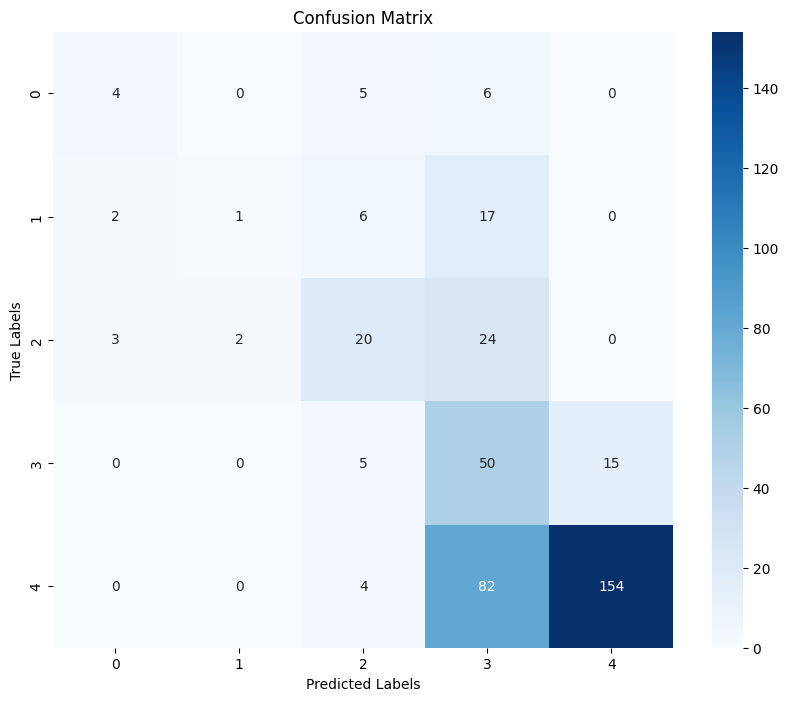

In [24]:
conf_matrix = confusion_matrix(valid_test_y, cats)

# Step 4: Display the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

No we will test the simple RAG implementation set-up in this script

In [25]:
#Generate RAG Knowledge-Base
RAG_size = x_split #full size
review_list = store_reviews_with_ratings(train_x[:RAG_size], train_y[:RAG_size])
stored_embeddings = encode_text_list(review_list)

In [26]:
cats, ids = convert_outputs(batch_prompt_model(x, mode="RAG"))
valid_test_y = clean_y(test_y[:set_size], ids)
print(f"Macro F1-Score of RAG prompting: {f1_score(valid_test_y, cats, average='macro')}")

Completed 10 prompts.
Completed 20 prompts.
Completed 30 prompts.
Completed 40 prompts.
Completed 50 prompts.
Completed 60 prompts.
Completed 70 prompts.
Completed 80 prompts.
Completed 90 prompts.
Completed 100 prompts.
Completed 110 prompts.
Completed 120 prompts.
Completed 130 prompts.
Completed 140 prompts.
Completed 150 prompts.
Completed 160 prompts.
Completed 170 prompts.
Completed 180 prompts.
Completed 190 prompts.
Completed 200 prompts.
Completed 210 prompts.
Completed 220 prompts.
Completed 230 prompts.
Completed 240 prompts.
Completed 250 prompts.
Completed 260 prompts.
Completed 270 prompts.
Completed 280 prompts.
Completed 290 prompts.
Completed 300 prompts.
Completed 310 prompts.
Completed 320 prompts.
Completed 330 prompts.
Completed 340 prompts.
Completed 350 prompts.
Completed 360 prompts.
Completed 370 prompts.
Completed 380 prompts.
Completed 390 prompts.
Completed 400 prompts.
Macro F1-Score of RAG prompting: 0.42022700310249783


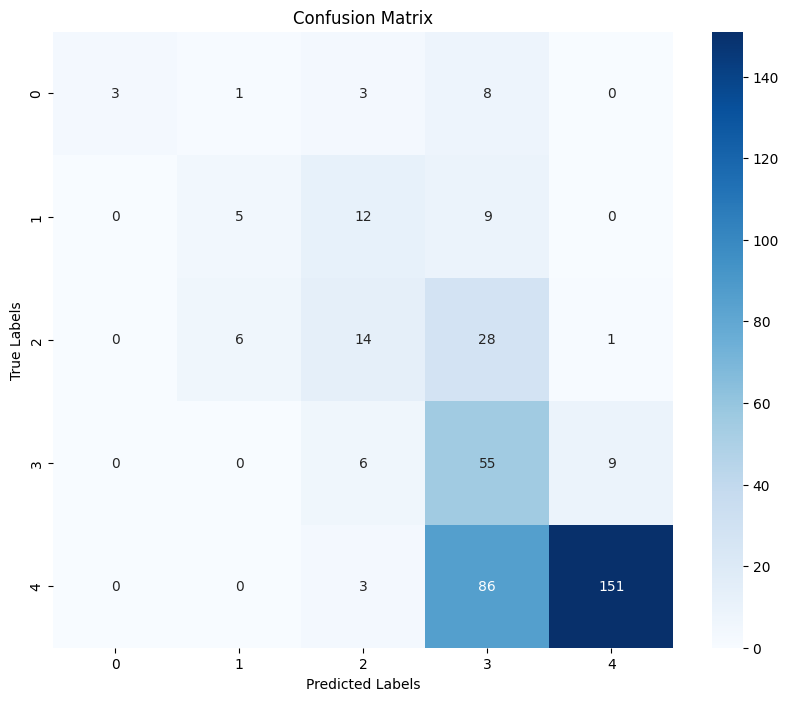

In [27]:
conf_matrix = confusion_matrix(valid_test_y, cats)

# Step 4: Display the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Let's try to benchmark this performance against a transfer learning approach

In [ ]:
#Define the model architecture class
class MulticlassTextClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(MulticlassTextClassificationModel, self).__init__()
        # Load the pre-trained model (e.g., BERT, RoBERTa, etc.)
        self.model = AutoModel.from_pretrained(model_name)
        
        # Add a larger dense layer (5000 neurons)
        self.dense_layer = nn.Linear(self.model.config.hidden_size, 32)
        self.relu = nn.ReLU()  # Activation function for the dense layer
        
        # Final classification layer
        self.classifier = nn.Linear(32, num_labels)  # This layer now takes 5000 neurons as input

    def forward(self, input_ids, attention_mask, labels=None):
        # Get model outputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token output for classification (outputs.last_hidden_state[:, 0, :])
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Pass the CLS token output through the dense layer
        dense_output = self.dense_layer(cls_output)
        dense_output = self.relu(dense_output)  # Apply ReLU activation
        
        # Classifier layer to get the final logits
        logits = self.classifier(dense_output)
        
        loss = None
        if labels is not None:
            # Compute loss using CrossEntropyLoss
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

#Definfe the dataset structure class
class CustomDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.labels = labels - 1 # Adjust labels to start from 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            # Return a new CustomDataset instance for a slice
            return CustomDataset(
                tokenized_data={
                    "input_ids": self.input_ids[idx],
                    "attention_mask": self.attention_mask[idx]
                },
                labels=self.labels[idx]
            )
        else:
            # Return a single sample as usual
            return {
                "input_ids": self.input_ids[idx],
                "attention_mask": self.attention_mask[idx],
                "labels": self.labels[idx] 
            }
    def __str__(self):
        # Display a summary of the dataset
        return (
            f"CustomDataset with {len(self)} samples\n"
            f"Input IDs: {self.input_ids.shape}\n"
            f"Attention Masks: {self.attention_mask.shape}\n"
            f"Labels: {self.labels.shape}"
        )

    def __repr__(self):
        # Display more details about the dataset for debugging
        content_preview = {
            "input_ids": self.input_ids[:3].tolist(),
            "attention_mask": self.attention_mask[:3].tolist(),
            "labels": self.labels[:3].tolist(),
        }
        return (
            f"CustomDataset(length={len(self)})\n"
            f"Preview of data:\n{content_preview}"
        )
        
# Load the F1 metric from the evaluate library
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred  # Unpack EvalPrediction object
    
    # Convert logits to predicted class labels
    preds = np.argmax(predictions, axis=1)
    
    # Compute weighted F1 score
    results = f1_metric.compute(predictions=preds, references=label_ids, average="weighted")
    
    return results
#Dataset prepraration
eval_set_size = len(train_x) // 20  # 20% of the training set for evaluation
max_length = 200 #max text token length
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text column for the train set
tokenized_train = tokenizer(
    train_x[eval_set_size:].tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors="pt"  # Directly return PyTorch tensors
)
# Add the labels as tensors
train_labels = torch.tensor(train_y[eval_set_size:])
train_dataset = CustomDataset(tokenized_train, train_labels)


# Tokenize the text column for the eval set
tokenized_eval = tokenizer(
    test_x[:eval_set_size].tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors="pt"  # Directly return PyTorch tensors
)
# Add the labels as tensors
eval_labels = torch.tensor(train_y[:eval_set_size])
eval_dataset = CustomDataset(tokenized_eval, eval_labels)
#Define the model and training arguments
model = MulticlassTextClassificationModel(model_name, num_labels=5)

training_args = TrainingArguments(output_dir="test_trainer", num_train_epochs=3, per_device_train_batch_size=380, evaluation_strategy="epoch")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)
# Freeze BERT layers (set requires_grad=False for all parameters in the BERT model)
for param in model.model.parameters():
    param.requires_grad = False

# Unfreeze the final custom layers (dense layer and classifier)
for param in model.dense_layer.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

# Check if custom layers are trainable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable layer: {name} with {param.numel()} parameters")
    else:
        print(f"Frozen layer: {name} with {param.numel()} parameters")


Frozen layer: model.embeddings.word_embeddings.weight with 23440896 parameters
Frozen layer: model.embeddings.position_embeddings.weight with 393216 parameters
Frozen layer: model.embeddings.LayerNorm.weight with 768 parameters
Frozen layer: model.embeddings.LayerNorm.bias with 768 parameters
Frozen layer: model.transformer.layer.0.attention.q_lin.weight with 589824 parameters
Frozen layer: model.transformer.layer.0.attention.q_lin.bias with 768 parameters
Frozen layer: model.transformer.layer.0.attention.k_lin.weight with 589824 parameters
Frozen layer: model.transformer.layer.0.attention.k_lin.bias with 768 parameters
Frozen layer: model.transformer.layer.0.attention.v_lin.weight with 589824 parameters
Frozen layer: model.transformer.layer.0.attention.v_lin.bias with 768 parameters
Frozen layer: model.transformer.layer.0.attention.out_lin.weight with 589824 parameters
Frozen layer: model.transformer.layer.0.attention.out_lin.bias with 768 parameters
Frozen layer: model.transformer.la

C:\Users\LaptopBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\LaptopBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [69]:
trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.5497350692749023, 'eval_f1': 0.0, 'eval_runtime': 0.174, 'eval_samples_per_second': 5.747, 'eval_steps_per_second': 5.747, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.5411264896392822, 'eval_f1': 0.0, 'eval_runtime': 0.154, 'eval_samples_per_second': 6.494, 'eval_steps_per_second': 6.494, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.5368542671203613, 'eval_f1': 0.0, 'eval_runtime': 0.2098, 'eval_samples_per_second': 4.768, 'eval_steps_per_second': 4.768, 'epoch': 3.0}
{'train_runtime': 8.0353, 'train_samples_per_second': 7.094, 'train_steps_per_second': 0.373, 'train_loss': 1.6287582715352376, 'epoch': 3.0}


TrainOutput(global_step=3, training_loss=1.6287582715352376, metrics={'train_runtime': 8.0353, 'train_samples_per_second': 7.094, 'train_steps_per_second': 0.373, 'total_flos': 0.0, 'train_loss': 1.6287582715352376, 'epoch': 3.0})

In [70]:
trainer.evaluate()

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.5368542671203613,
 'eval_f1': 0.0,
 'eval_runtime': 0.325,
 'eval_samples_per_second': 3.077,
 'eval_steps_per_second': 3.077,
 'epoch': 3.0}

In [ ]:
# Get the fine-tuned model from the trainer
model = trainer.model
model.eval()  # Ensure the model is in evaluation mode

# Lists to store predictions
predictions = []

# Iterate through each text string
for sample in x:
    # Tokenize the input text
    inputs = tokenizer(sample, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

    # Perform inference (turn off gradients)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits and calculate the predicted class (using argmax)
    logits = outputs["logits"]
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Append the predicted class to the list
    predictions.append(predicted_class)

# Calculate F1 score (you can use weighted average or other options)
f1 = f1_score(y, predictions, average='macro')

# Output the F1 score
print(f"F1 score: {f1:.4f}")

F1 score: 0.0000


Noice!

In [139]:
# Tokenize the text data
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_x)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(train_x)

max_length = 200
padded_sequences = pad_sequences(
    sequences, 
    maxlen=max_length,  # Set the maximum sequence length
    padding='post',     # Pad shorter sequences at the end
    truncating='post'   # Truncate longer sequences at the end
)

In [ ]:
LSTM_model = Sequential()
LSTM_model.add(Embedding(15000, output_dim=32, input_length=max_length, mask_zero=True))
LSTM_model.add(LSTM(32, return_sequences=True))
LSTM_model.add(LSTM(32, return_sequences=True))
LSTM_model.add(LSTM(32))
LSTM_model.add(Dense(5, activation='softmax'))
LSTM_model.compile('adam', 'sparse_categorical_crossentropy', metrics=[macro_f1_score])

LSTM_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 200, 32)           480000    
                                                                 
 lstm_54 (LSTM)              (None, 200, 32)           8320      
                                                                 
 lstm_55 (LSTM)              (None, 200, 32)           8320      
                                                                 
 lstm_56 (LSTM)              (None, 32)                8320      
                                                                 
 dense_18 (Dense)            (None, 5)                 165       
                                                                 
Total params: 505125 (1.93 MB)
Trainable params: 505125 (1.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
LSTM_model.fit(padded_sequences,train_y-1, epochs=2)


Epoch 1/2
313/313 [==============================] - 63s 203ms/step - loss: 1.0246 - weighted_f1_score: 15.4723
Epoch 2/2
313/313 [==============================] - 64s 205ms/step - loss: 0.8512 - weighted_f1_score: 13.6041


In [145]:
test=pad_sequences(tokenizer.texts_to_sequences(["total dogshit,I hate it! Expensive and dull!"]), maxlen=max_length, padding='post', truncating='post')

In [146]:
LSTM_model.predict(test)

1/1 [==============================] - 0s 82ms/step


array([[0.1731171 , 0.20938982, 0.27447328, 0.20290712, 0.14011274]],
      dtype=float32)